In [1]:
import torch
from torch.utils.data import DataLoader
import json
!pip install datasets
!pip install zstandard
!pip install transformers
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 2.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.0/264.0 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.6/769.6 kB 7.6 MB/s eta 0:00:0000:01


In [4]:
## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print("total memory: ", t, "reserve mem: ", r, "total-reserved:", t-r, "allocated:", a,"\n (total-reserved)/total:", (t-r)/t,"(reserved-allocated)/reserved:", (r-a)/r)
    return 

In [5]:
## Model and tokenizer
model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

model_name = "EleutherAI/pythia-1.4B-deduped"
model_revision = "step143000"
model_cache_dir = "./pythia-1.4B-deduped/step143000"

device = "cuda" if torch.cuda.is_available() else "cpu"

model.half()
model.eval()
model.to(device)
mem_stats()

total memory:  16935419904 reserve mem:  2946498560 total-reserved: 13988921344 allocated: 2929983488 
 (total-reserved)/total: 0.8260156183488511 (reserved-allocated)/reserved: 0.005604982206405694


In [6]:
## Collate functions for loading dataset
def collate_fn(batch):
    tokens = [tokenizer.encode(example["text"], return_tensors="pt", truncation=True) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return tokens_padded

def collate_already_encoded(batch):
    tokens = batch
    max_length = max([len(t['tokens']) for t in tokens])
    tokens_padded = torch.zeros((len(tokens),max_length),dtype=torch.int)
    for i in range(len(tokens)):
        tokens_padded[i,:] = torch.Tensor(tokens[i]['tokens'])
    return tokens_padded


In [7]:
## Training and validation datasets
training_dataset = load_dataset("EleutherAI/pile-deduped-pythia-random-sampled", split="train")
validation_dataset = load_dataset("the_pile_val.py", split="validation") 
mem_stats()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5000000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


No config specified, defaulting to: the_pile_val/all


Generating validation split: 0 examples [00:00, ? examples/s]

Dataset the_pile_val downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30. Subsequent calls will reuse this data.
total memory:  16935419904 reserve mem:  2946498560 total-reserved: 13988921344 allocated: 2929983488 
 (total-reserved)/total: 0.8260156183488511 (reserved-allocated)/reserved: 0.005604982206405694


In [8]:
## Dataloader 
bs = 8
training_dataloader = DataLoader(training_dataset, batch_size = bs, collate_fn=collate_already_encoded, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = bs, collate_fn=collate_fn, shuffle = True)
mem_stats()

total memory:  16935419904 reserve mem:  2946498560 total-reserved: 13988921344 allocated: 2929983488 
 (total-reserved)/total: 0.8260156183488511 (reserved-allocated)/reserved: 0.005604982206405694


In [16]:
nbatches = 200 ## Number of batches to gather data on. Number of data points is ns * nbatches
samplelength = 20 ## How long are the sequences we take from the training and validation sets.

In [17]:
## Training dataset information
training_sum_perplexity = torch.zeros((nbatches, bs))
for batchno, training_x in enumerate(training_dataloader):
    if batchno >= nbatches:
        break
    with torch.no_grad():       
        ## Get predictions on training data                       
        training_x = training_x[:,:samplelength].to(device).detach()
        mask  = (training_x>0).detach()                                     

        model.train(False)
        logits_training = model(input_ids=training_x, attention_mask = mask)

        ## Find sum of log likelihood of each sequence
        for batch in range(bs):
            seq_logits = torch.zeros((len(training_x[0])))
            
            ## Find sum of log likelihood of each sequence
            for idx, w in enumerate(training_x[batch,]):
                if training_x[batch,idx] == 0:
                    break
                seq_logits[idx] = logits_training.logits[batch,idx,w]
            
            ## Case for when we reach the end of the sequence
            if training_x[batch,idx] != 0:
                idx += 1

            ## Compute perplexity
            training_sum_perplexity[batchno, batch]= torch.sum(seq_logits[:idx]-torch.log(1+torch.exp(seq_logits[:idx])))/idx

            ## Clean up 
            del seq_logits
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        ## Cleaning up
        del training_x, mask, logits_training
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    if batchno % 20 == 0:
        print("Training batch no. ", batchno)  
        print("Memory after training")
        mem_stats()
        print()

Training batch no.  0
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504192 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976113902385159

Training batch no.  20
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504192 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976113902385159

Training batch no.  40
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504192 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976113902385159

Training batch no.  60
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504192 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976113902385159

Training batch no.  80
Me

In [18]:
validation_sum_perplexity = torch.zeros((nbatches, bs))
for batchno, validation_x in enumerate(validation_dataloader):
    if batchno >= nbatches:
        break
    with torch.no_grad():               
        ## Get predictions on validation data                 
        validation_x = validation_x[:,:samplelength].to(device).detach()
        mask  = (validation_x>0).detach()                                     

        model.train(False)
        logits_validation = model(input_ids=validation_x, attention_mask = mask)

        ## Find sum of log likelihood of each sequence
        for batch in range(bs):
            seq_logits = torch.zeros((len(validation_x[0])))

            ## Find logits of each word in the sequence
            for idx, w in enumerate(validation_x[batch,]):
                if validation_x[batch,idx] == 0:
                    break
                seq_logits[idx] = logits_validation.logits[batch,idx,w]
            if validation_x[batch,idx] != 0:
                idx += 1
            validation_sum_perplexity[batchno, batch]= torch.sum(seq_logits[:idx]-torch.log(1+torch.exp(seq_logits[:idx])))/idx

            ## Clean up 
            del seq_logits
            torch.cuda.empty_cache()
            torch.cuda.synchronize()


        ## Cleaning up
        del validation_x, mask, logits_validation
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    if batchno % 20 == 0:
        print("Training batch no. ", batchno)  
        print("Memory after training")
        mem_stats()
        print()

Training batch no.  0
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504704 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976096648630742

Training batch no.  20
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504704 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976096648630742

Training batch no.  40
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504704 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976096648630742

Training batch no.  60
Memory after training
total memory:  16935419904 reserve mem:  2967470080 total-reserved: 13967949824 allocated: 2938504704 
 (total-reserved)/total: 0.8247772953477753 (reserved-allocated)/reserved: 0.00976096648630742

Training batch no.  80
Me

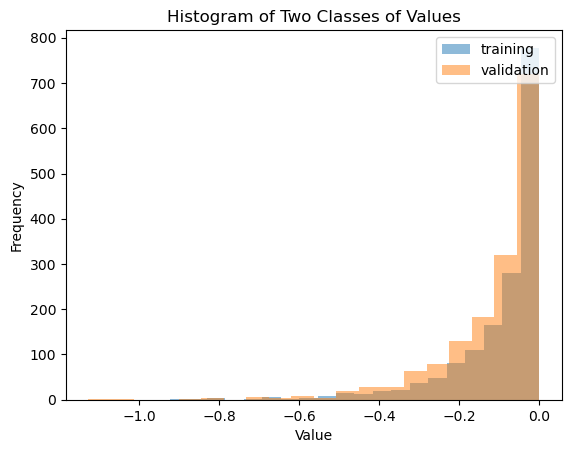

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# generate two sets of random values
with torch.no_grad():
    valuestraining   = torch.flatten(training_sum_perplexity) 
    valuesvalidation = torch.flatten(validation_sum_perplexity)

# create a figure and axis object
fig, ax = plt.subplots()

# plot a histogram of the first set of values with 20 bins
ax.hist(valuestraining, bins=20, alpha=0.5, label='training')

# plot a histogram of the second set of values with 20 bins
ax.hist(valuesvalidation, bins=20, alpha=0.5, label='validation')

# add a legend to the plot
ax.legend(loc='upper right')

# add labels and a title to the plot
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Two Classes of Values')

# show the plot
plt.show()

tensor(-1.1260) tensor(0.)


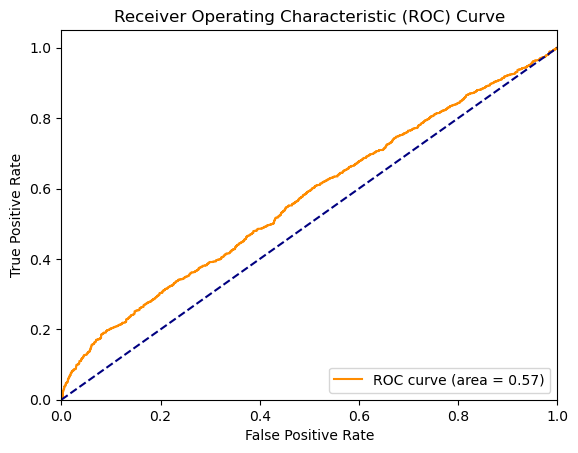

In [20]:
from sklearn.metrics import roc_curve, auc

## Scale all values to be between 0 and 1
st = min(valuestraining.min(),valuesvalidation.min())
end = max(valuestraining.max(),valuesvalidation.max())
print(st,end)

y_scores =  torch.cat((valuestraining, valuesvalidation))
y_scores = y_scores-min(y_scores)
y_scores = y_scores/max(y_scores)
y_true   = [1 for _ in range(len(valuestraining))] + [0 for _ in range(len(valuesvalidation))]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("test.png")